# Find the normal knee image with most slices and prepare data for VoxelMorph

## Find the normal knee image with most slices in a folder

In [43]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load csv file
normalImageIndices = []
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    # Find all the rows with abnormal as 0 and store their indices
    for row in fileReader:
        if (row[1] == '0'):
            normalImageIndices.append(row[0])

In [10]:
print(normalImageIndices)

['0011', '0012', '0014', '0017', '0021', '0023', '0025', '0026', '0040', '0044', '0048', '0053', '0060', '0066', '0074', '0077', '0082', '0096', '0099', '0106', '0110', '0117', '0118', '0120', '0122', '0123', '0127', '0128', '0131', '0143', '0144', '0149', '0153', '0170', '0177', '0181', '0210', '0214', '0222', '0225', '0227', '0228', '0230', '0238', '0239', '0243', '0244', '0245', '0252', '0256', '0258', '0267', '0268', '0272', '0283', '0291', '0296', '0299', '0306', '0337', '0342', '0362', '0363', '0372', '0377', '0381', '0384', '0387', '0400', '0404', '0406', '0409', '0410', '0415', '0420', '0425', '0428', '0430', '0434', '0435', '0437', '0439', '0442', '0450', '0459', '0460', '0461', '0462', '0465', '0466', '0467', '0472', '0473', '0475', '0476', '0477', '0491', '0492', '0495', '0499', '0503', '0504', '0509', '0515', '0525', '0532', '0533', '0542', '0548', '0549', '0558', '0563', '0565', '0571', '0580', '0583', '0588', '0589', '0597', '0599', '0600', '0608', '0621', '0625', '0634',

In [20]:
# Check whether all images have same 2D shape
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    x = None
    y = None
    for row in fileReader:
        index = row[0]
        temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
        if (x == None and y == None):
            x = temp.shape[1]
            y = temp.shape[2]
        elif (x != temp.shape[1] or y != temp.shape[2]):
            print('There are images which have different 2D shape')

In [14]:
# Check which image has most slices
maxSlice = 0
resultIndex = None
for index in normalImageIndices:
    temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    if (temp.shape[0] > maxSlice):
        resultIndex = index
        maxSlice = temp.shape[0]
        
print(maxSlice)
print(resultIndex)

52
0934


(46, 256, 256)


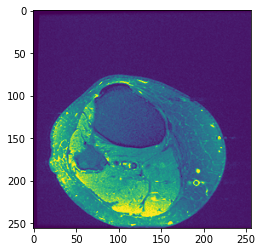

In [39]:
# Try to paddle one image
temp = np.load('./MRNet-v1.0/train/axial/0000.npy')
temp = np.pad(temp, ((0, 2), (0, 0), (0, 0)))
# print(temp)
print(temp.shape)
plt.imshow(temp[41,:,:])
np.save('./MRNet-forVoxelMorph/processedData/0000', temp)

In [48]:
# Paddle zeros for all images with fewer slices (discard images with more slices)
savePath = './MRNet-forVoxelMorph/processedData/{}'
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    for row in fileReader:
        index = row[0]
        temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
        if (temp.shape[0] > maxSlice):
            continue
        else:
            numSliceToPaddle = maxSlice - temp.shape[0]
            temp = np.pad(temp, ((0, numSliceToPaddle), (0, 0), (0, 0)))
            np.savez(savePath.format(index), vol_data = temp)

In [49]:
# Check if everything is right
for filename in os.listdir('./MRNet-forVoxelMorph/processedData'):
    temp = np.load(savePath.format(filename))['vol_data']
    if (temp.shape != (52, 256, 256)):
        print('error')

In [52]:
# Convert the atlas npy file into npz file
atlas = np.load('./MRNet-forVoxelMorph/atlas.npy')
np.savez('./MRNet-forVoxelMorph/atlas', vol = atlas)